In [135]:
import sys
import math
import tensorflow as tf
import numba as nb
from numba import njit, prange
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

In [201]:
@njit(cache=True, parallel=True)
def mult(bs, x, y, res):
    n = len(x[0])
    m = len(y[0])
    for b in range(bs):
        for i in prange(n):
            for j in range(m):
                res[i,j] += x[b,i]*y[b,j]

class Sigmoid:
    def calc(self, X):
        self.sigmoid = 1.0/(1.0+np.exp(-X))
        return self.sigmoid#[:] return copy
    def grad(self, vec_top_grad):
        return vec_top_grad*self.sigmoid*(1.0-self.sigmoid)

class LeakyReLU:
    def __init__(self):
        self.alpha = 0.1
    def calc(self, X):
        self.LeakyReLU = np.where(X>0,X, self.alpha*X)
        return self.LeakyReLU#[:] return copy
    def grad(self, vec_top_grad):
        return vec_top_grad*np.where(self.LeakyReLU>0, 1.0, self.alpha)
    
class SoftMax:
    def __init__(self, n, self.ba):
        self.n = n
        self.tmp = np.empty((n,n), dtype='float32')
        self.softmax = np.empty(n, dtype='float32')
    def calc(self, X):
        #print('x in softmax', max(X))
        self.softmax = np.exp(X)
        self.softmax /= np.sum(self.softmax)
        return self.softmax
    def grad(self, vec_top_grad):
        mult(-self.softmax, self.softmax, self.tmp)
        self.tmp[np.diag_indices_from(self.tmp)] += self.softmax#*(1.0-self.softmax)
        return np.dot(vec_top_grad, self.tmp)
    
def initW(n_input, n_output): # Xavier init
    tmp1 = np.random.normal(0.0, 2.0/(n_input+n_output), size=n_input*n_output)
    tmp1 = tmp1.reshape(n_input,n_output).astype('float32')
    tmp2 = np.random.normal(0.0, 2.0/(n_output+n_output), size=n_output).astype('float32')
    return tmp1, tmp2

In [188]:
class CrossEntropy:
    def __init__(self, num_classes, batch = 1, eps = 1e-6):
        self.num_classes = num_classes
        self.drop_grad = np.zeros((batch, num_classes), dtype='float32')
        self.batch = batch
        self.eps = eps
    def calc(self, X, labels):
        self.X = X
        cross = 0.0
        for i in range(len(labels)):
            self.X[i,labels[i]] = X[i,labels[i]].clip(min=self.eps, max=1.0)
            cross -= np.log(self.X[i,labels[i]])
        return cross / len(labels)
    def grad(self, labels):
        self.drop_grad.fill(0.0)
        for i in range(len(labels)):
            self.drop_grad[i, labels[i]] = -1.0/self.X[i, labels[i]]
        return self.drop_grad

class Net:
    const_coeff = 0.1
    coeff = 0.1
    def __init__(self, layers, num_classes, batch = 1):
        self.layers = layers
        self.n_layers = len(layers)
        self.cross = CrossEntropy(num_classes, batch)
        self.batch = batch
    def calc(self, x):
        res = None
        for layer in self.layers:
            res = layer.calc(x)
            x = res
        return res
    def get_class(self, x):
        res = self.calc(x)
        return np.argmax(res), res
    def fit(self, X, Y, n):
        Net.coeff = Net.const_coeff
        loss = np.zeros(shape=(n, len(Y)), dtype='float32')
        for it in range(n):
            print('EPOCH',it+1)
            for i in range(0, len(Y), self.batch):
                res = self.calc(X[i:i+self.batch])
                # cross res
                loss[it, i] = self.cross.calc(res, Y[i:i+self.batch])
                gr = self.cross.grad(Y[i:i+self.batch])
                for layer in reversed(self.layers):
                    gr = layer.grad(gr)
            Net.coeff *= 0.90
        return loss.flatten()
                

In [233]:
class FullConnected:
    def __init__(self, W, b, batch=1):
        self.W = W
        self.b = b
        self.batch = 1
        self.n_input = len(W)
        self.n_output = len(b)
        self.new_grad = np.zeros((self.n_input,self.n_output), dtype='float32')
        self.res = np.zeros(self.n_output, dtype='float32')
    def calc(self, x):
        self.x = x#[:] copy
        #vec(x)*matr(W)=vec(y)
        self.res = np.dot(x, self.W)# матрица из batch строк и output cтолбцов
        self.res += self.b
        #print('max W, b, res',np.max(self.W), np.max(self.b), np.max(self.res))
        return self.res
    def grad(self, vec_top_grad):
        # поиск производной выхода y по входу x: d(y)/d(x)
        next_grad = np.matmul(self.W, vec_top_grad.T).T #порядок умножения?
        
        # поиск производной по W
        self.new_grad.fill(0.0)
        mult(self.batch, self.x, vec_top_grad, self.new_grad)
        self.W -= Net.coeff*self.new_grad #Net.coef коэффициент градиентного спуска
        
        # поиск производной по b
        self.b -= Net.coeff*vec_top_grad[:].sum(axis=0)
        return next_grad

In [5]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle('data/data_batch_1')

In [6]:
from PIL import Image
print(data.keys())
start, end = 2, 23
img_ars = data[b'data'][start:end]
img_labels = data[b'labels'][start:end]
print(len(data[b'labels']))
print(len(img_ars[0]))
print(type(img_ars[0]))
img_ars = img_ars
for img_ar,i in zip(img_ars, range(start,end)):
    img = Image.fromarray(np.transpose(np.reshape(img_ar,(3, 32,32)), (1,2,0)), 'RGB')
    #img.save(str(i)+'.png')
#print(img_labels)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
10000
3072
<class 'numpy.ndarray'>


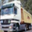

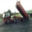

EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
0.13545305
9 9
4 4
1 1
1 1
2 2
7 7
8 8
3 3
4 4
7 7
7 7
2 2
9 9
9 9
9 9
3 3
2 2
6 6
4 4
3 3
6 6


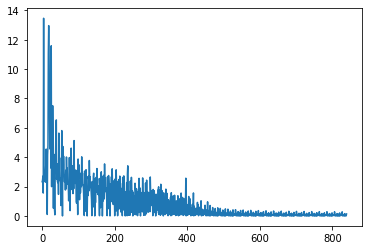

In [8]:
num_classes = 10
n_input = len(img_ars[0])
np.random.seed(0)

cross = CrossEntropy(num_classes)
x = (img_ars/255.0).astype('float32')
labels = img_labels
#print(labels)
l1 = FullConnected(*initW(n_input, 192))
leakyReLU = LeakyReLU()
l2 = FullConnected(*initW(192, num_classes))
softmax = SoftMax(num_classes)

net = Net([l1, leakyReLU, l2, softmax],num_classes)
loss = net.fit(x, labels, 40)
print(loss[-1])
plt.plot(loss)
for i in range(len(x)):
    calc_class, res = net.get_class(x[i])
    print(labels[i], calc_class)
    #print(res)

In [236]:
num_classes = 10
n_input = len(img_ars[0])
np.random.seed(0)
batch = 1

cross = CrossEntropy(num_classes)
x = (img_ars/255.0).astype('float32')
labels = img_labels
#print(labels)
l1 = FullConnected(*initW(n_input, 192))
leakyReLU = LeakyReLU()
l2 = FullConnected(*initW(192, num_classes))
softmax = SoftMax(num_classes)

net = Net([l1, leakyReLU, l2, softmax],num_classes, batch)
loss = net.fit(x, labels, 1)
#print(loss[-1])
net.get_class(x[0])

EPOCH 1


TypeError: not enough arguments: expected 4, got 3